<a href="https://colab.research.google.com/github/fawaaazi/test/blob/main/BERT_Confusion_Matrix_(GPU_Enabled).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preparing the IMDb dataset...
Tokenizing the data for BERT...


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Using the pre-trained BERT model for prediction...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Making predictions and generating the confusion matrix...


Visualizing the confusion matrix...


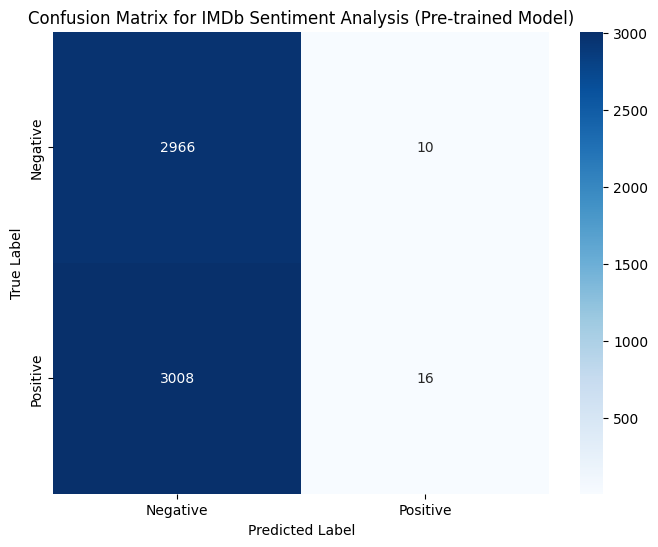


Confusion Matrix:
True Positives (TP): 16
True Negatives (TN): 2966
False Positives (FP): 10
False Negatives (FN): 3008

Metrics for 'Positive' class:
Precision: 0.62
Recall: 0.01
F1-Score: 0.01


In [3]:
# Before running, make sure to install the required libraries:
# pip install transformers datasets scikit-learn matplotlib seaborn torch torch_xla
!pip install datasets
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# --- GPU Setup ---
# Check if CUDA (GPU) is available and set the device accordingly
# This will detect a T4 GPU if it's assigned in your Colab runtime.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- 1. Load and Prepare the Dataset ---
print("Loading and preparing the IMDb dataset...")

# Load the IMDb dataset.
dataset = load_dataset("imdb")

# Use a small fraction of the training data for a fast demonstration (if needed for Trainer init).
# train_subset = dataset["train"].shuffle(seed=42).select(range(1000))

# Use the entire test split for evaluation. The IMDb test split has 25,000 samples.
test_subset = dataset["test"].shuffle(seed=42).select(range(6000))

# The dataset is pre-labeled with 'label': 0 (negative) and 1 (positive).

# --- 2. Tokenize the Data ---6
print("Tokenizing the data for BERT...")

# Load the pre-trained BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    # This function tokenizes the text and returns a dictionary of inputs for the model.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenizer to the training and testing subsets.
#tokenized_train_subset = train_subset.map(tokenize_function, batched=True)
tokenized_test_subset = test_subset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors and specify the columns needed for the model.
# For TPU, we set the format to 'torch' as xla handles the device placement.
# tokenized_train_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# --- 3. Use the Pre-trained BERT Model for Prediction ---
print("Using the pre-trained BERT model for prediction...")

# Load the pre-trained BERT model for sequence classification.
# Note: We are NOT fine-tuning this model, just using its pre-trained weights.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move the model to the XLA device (TPU core).
model.to(device)

# We still use the Trainer for its convenient prediction functionality.
# We define minimal arguments since we are skipping the training process.
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8, # You can often use much larger batch sizes on TPU
    # The following argument is crucial for TPU usage with Trainer
    no_cuda=False, # Ensure CUDA is not explicitly disabled, as XLA handles device
)

# Initialize the Trainer object.
# The Trainer will automatically handle moving batches to the XLA device during prediction
# when running in a TPU environment and torch_xla is configured.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_test_subset, # train_dataset is still needed for Trainer initialization
)

# We skip the trainer.train() call. This ensures no fine-tuning occurs.

# --- 4. Make Predictions and Generate the Confusion Matrix ---
print("Making predictions and generating the confusion matrix...")

# Disable gradients for prediction to save memory and speed up computation.
with torch.no_grad():
    # Make predictions on the test dataset.
    predictions = trainer.predict(tokenized_test_subset)

# Extract the predicted labels from the model output.
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test dataset.
true_labels = np.array(tokenized_test_subset["label"])

# Generate the confusion matrix.
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names for a better visual representation.
class_names = ["Negative", "Positive"]

# --- 5. Visualize the Confusion Matrix ---
print("Visualizing the confusion matrix...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for IMDb Sentiment Analysis (Pre-trained Model)')
plt.show()

# Print the confusion matrix values for clarity.
print("\nConfusion Matrix:")
print(f"True Positives (TP): {cm[1, 1]}")
print(f"True Negatives (TN): {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")

# You can also calculate precision, recall, and F1-score from this matrix.
# For example, for the 'Positive' class (label 1):
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMetrics for 'Positive' class:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

In [4]:
test_subset = dataset["test"].shuffle(seed=42).select(range(6000))

print("Tokenizing the data for BERT...")

# Load the pre-trained BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    # This function tokenizes the text and returns a dictionary of inputs for the model.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenizer to the training and testing subsets.
#tokenized_train_subset = train_subset.map(tokenize_function, batched=True)
tokenized_test_subset = test_subset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors and specify the columns needed for the model.
# For TPU, we set the format to 'torch' as xla handles the device placement.
# tokenized_train_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# --- 3. Use the Pre-trained BERT Model for Prediction ---
print("Using the pre-trained BERT model for prediction...")

# Load the pre-trained BERT model for sequence classification.
# Note: We are NOT fine-tuning this model, just using its pre-trained weights.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.to(device)


Tokenizing the data for BERT...


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Using the pre-trained BERT model for prediction...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8, # You can often use much larger batch sizes on TPU
    # The following argument is crucial for TPU usage with Trainer
    no_cuda=False, # Ensure CUDA is not explicitly disabled, as XLA handles device
)

# Initialize the Trainer object.
# The Trainer will automatically handle moving batches to the XLA device during prediction
# when running in a TPU environment and torch_xla is configured.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_test_subset, # train_dataset is still needed for Trainer initialization
)

# We skip the trainer.train() call. This ensures no fine-tuning occurs.

# --- 4. Make Predictions and Generate the Confusion Matrix ---
print("Making predictions and generating the confusion matrix...")

# Disable gradients for prediction to save memory and speed up computation.
with torch.no_grad():
    # Make predictions on the test dataset.
    predictions = trainer.predict(tokenized_test_subset)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Making predictions and generating the confusion matrix...


Visualizing the confusion matrix...


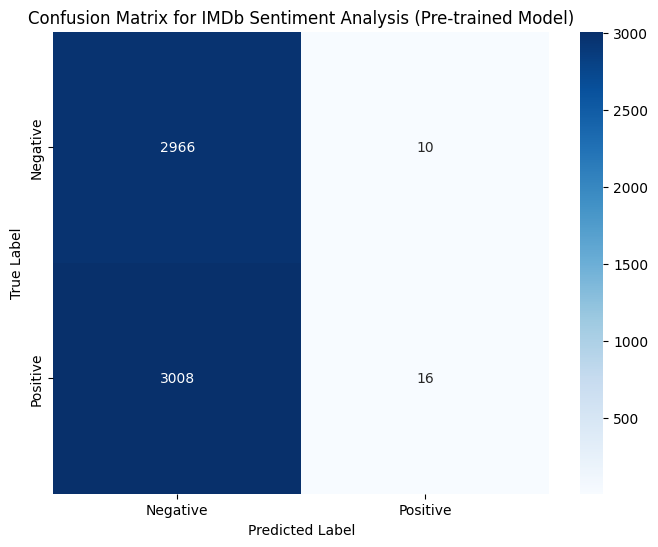


Confusion Matrix:
True Positives (TP): 16
True Negatives (TN): 2966
False Positives (FP): 10
False Negatives (FN): 3008

Metrics for 'Positive' class:
Precision: 0.62
Recall: 0.01
F1-Score: 0.01


In [6]:
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the test dataset.
true_labels = np.array(tokenized_test_subset["label"])

# Generate the confusion matrix.
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names for a better visual representation.
class_names = ["Negative", "Positive"]

# --- 5. Visualize the Confusion Matrix ---
print("Visualizing the confusion matrix...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for IMDb Sentiment Analysis (Pre-trained Model)')
plt.show()

# Print the confusion matrix values for clarity.
print("\nConfusion Matrix:")
print(f"True Positives (TP): {cm[1, 1]}")
print(f"True Negatives (TN): {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")

# You can also calculate precision, recall, and F1-score from this matrix.
# For example, for the 'Positive' class (label 1):
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMetrics for 'Positive' class:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")